In [1]:
from google.colab import drive
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, classification_report
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.model_selection import GridSearchCV
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import numpy as np

In [2]:
def plot_learning_curve(model, X, y, X_train=None, X_val=None, y_train=None, y_val=None):

  if X_train is None: 
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, stratify=y, random_state=27)
  train_errors, val_errors = [], []
  train_size = np.linspace(10, len(X_train), 10).astype(int)
  for m in train_size:
    model.fit(X_train[:m], y_train[:m])
    y_train_predict = model.predict(X_train[:m])
    y_val_predict = model.predict(X_val)

    train_errors.append(f1_score(y_train[:m], y_train_predict, average='macro'))
    val_errors.append(f1_score(y_val, y_val_predict, average= 'macro'))
  plt.grid()
  plt.plot(train_size, train_errors, 'r', label= 'Training Error')
  plt.plot(train_size, val_errors, 'b', label = 'Validation Error')
  plt.ylabel('F1 Macro Score')
  plt.xlabel('Training Example Size')
  plt.legend(loc='best')

In [3]:
def plot_learning_curve_hyper(df, x_axis_label, y_axis_label, title, ax=None, ylim=None):
  x = []
  for ele in df.params:
    for k, v in ele.items():
      x.append(v)
  if ax is None:
    _, ax = plt.subplots(figsize=(14, 10))

  ax.set_title(title)
  if ylim is not None:
    ax.set_ylim(*ylim)
  ax.set_xlabel(x_axis_label)
  ax.set_ylabel(y_axis_label)
  ax.grid()
  ax.fill_between(
    x,
    (df['mean_train_score'] - df['std_train_score']).values,
    (df['mean_train_score'] + df['std_train_score']).values,
    alpha=0.1,
    color="r",
    )
  ax.fill_between(
    x,
    (df['mean_test_score'] - df['std_test_score']).values,
    (df['mean_test_score'] + df['std_test_score']).values,
    alpha=0.1,
    color="g",
    )
  ax.plot(x, df['mean_train_score'], "x-", color = 'r', label = 'Training Score')
  ax.plot(x, df['mean_test_score'], "x-", color = 'g', label = 'Cross-validation Score')
  ax.legend(loc="best")

In [4]:
def up_sampling(X_train, y_train):
  #Concatonate our our training data back together
  X = pd.concat([X_train, y_train], axis=1)
  #Seprate Minority and Majority Class
  opened_account = X[X['Personal Loan'] == 1]
  not_opened_account = X[X['Personal Loan'] == 0]
  #Upsample the Minority Class
  opened_account_upsampled = resample(opened_account,
                                      replace = True, #sample with replacement
                                      n_samples= len(not_opened_account), #match the number of not opened account
                                      random_state = 27)
  upsampled = pd.concat([opened_account_upsampled, not_opened_account])
  return upsampled

In [5]:
def synthetic_samples(X_train, y_train):
  sm = SMOTE(random_state=27)
  X_train, y_train = sm.fit_resample(X_train, y_train)

  return X_train, y_train

In [6]:
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
% cd '/content/drive/MyDrive/Georgia Tech/Machine Learning-CS7641/Assignments/Assignment #1/Loan_Model_DT'

/content/drive/MyDrive/Georgia Tech/Machine Learning-CS7641/Assignments/Assignment #1/Loan_Model_DT


In [8]:
df = pd.read_excel('Bank_Personal_Loan_Modelling.xlsx', sheet_name='Data')

In [9]:
X = df.drop(['Personal Loan', 'ID', 'ZIP Code'], axis=1)
y = df['Personal Loan']

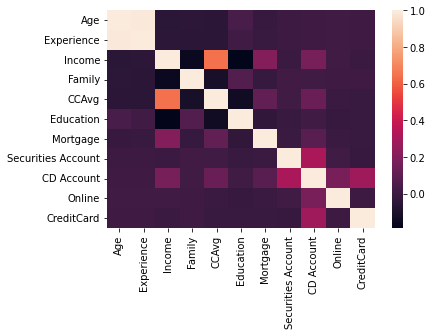

In [10]:
# Checking Corelation heatmap
import seaborn as sns
corr = X.corr()
sns.heatmap(corr)

In [11]:
#Dropping Age column for colinearity
X.drop('Age', axis=1, inplace=True)

In [12]:
#Split the dataset to train, test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.25,
                                                    random_state=27,stratify=y)

In [13]:
#Group Columns based on type
normal_col = ['Experience']
skewd_col = ['Income', 'CCAvg', 'Mortgage']
cat_col = ['Family', 'Education']

In [14]:
#Make Copy of X_train and X_test
X_train_stand = X_train.copy()
X_test_stand = X_test.copy()

In [15]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PowerTransformer, OneHotEncoder
from sklearn.compose import ColumnTransformer

normal_pipeline = Pipeline(steps = [('scale', StandardScaler())])
skewd_pipline = Pipeline(steps = [('sk_scale', PowerTransformer())])
cat_pipeline = Pipeline(steps=[('one_hot', OneHotEncoder())])

full_preprocessor = ColumnTransformer(transformers=[
        ('normal_transform', normal_pipeline, normal_col),
        ('skewd_transform', skewd_pipline, skewd_col),
        ('Categorical_onhot', cat_pipeline, cat_col)],remainder ='passthrough')

X_train_stand = full_preprocessor.fit_transform(X_train_stand)
X_test_stand = full_preprocessor.transform(X_test_stand)

In [16]:
#Try Quick and Dirty KNN Classifier

clf_knn = KNeighborsClassifier()

clf_knn.fit(X_train, y_train)

y_pred = clf_knn.predict(X_test)

print(f'Classification Report on Test Set: {classification_report(y_pred, y_test)}')

Classification Report on Test Set:               precision    recall  f1-score   support

           0       0.97      0.93      0.95      1180
           1       0.32      0.54      0.40        70

    accuracy                           0.91      1250
   macro avg       0.64      0.74      0.68      1250
weighted avg       0.94      0.91      0.92      1250



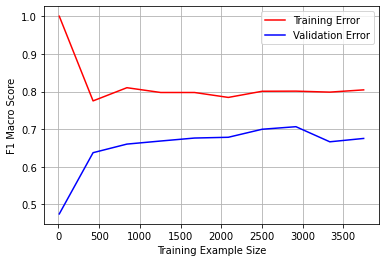

In [17]:
plot_learning_curve(clf_knn, X, y)

In [18]:
y_predTrain = clf_knn.predict(X_train)
print(f'Classification Report on Test Set: {classification_report(y_predTrain, y_train)}')

Classification Report on Test Set:               precision    recall  f1-score   support

           0       0.99      0.95      0.97      3513
           1       0.53      0.81      0.64       237

    accuracy                           0.94      3750
   macro avg       0.76      0.88      0.80      3750
weighted avg       0.96      0.94      0.95      3750



In [19]:
from sklearn import neighbors
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

clf = KNeighborsClassifier()
# Test for best number of neighbors
param_grid = [{'n_neighbors': [i for i in range(2, 20)]}]
grid_search = GridSearchCV(clf, param_grid= param_grid, cv=4, n_jobs=-1,
                           return_train_score=True, scoring='f1_macro')

grid_search.fit(X_train_stand, y_train)

GridSearchCV(cv=4, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid=[{'n_neighbors': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                          13, 14, 15, 16, 17, 18, 19]}],
             return_train_score=True, scoring='f1_macro')

In [20]:
df_neighbor = pd.DataFrame(grid_search.cv_results_)
grid_search.best_params_

{'n_neighbors': 3}

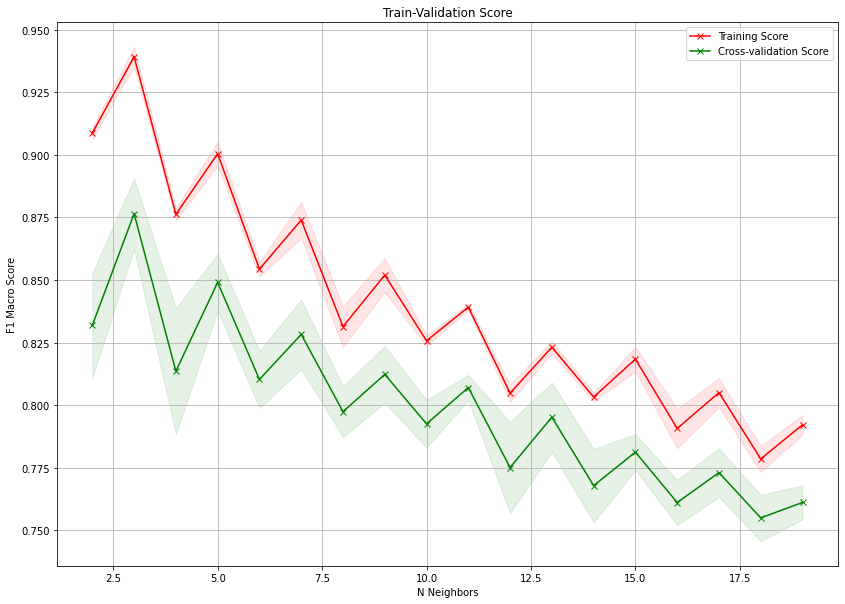

In [21]:
plot_learning_curve_hyper(df_neighbor, 'N Neighbors', 'F1 Macro Score', 'Train-Validation Score')

In [22]:
from sklearn import neighbors
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

clf = KNeighborsClassifier()
# Test for best number of neighbors
param_grid = [{'weights': ['uniform', 'distance']}]
grid_search = GridSearchCV(clf, param_grid= param_grid, cv=5, n_jobs=-1,
                           return_train_score=True, scoring='f1_macro')

grid_search.fit(X_train_stand, y_train)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid=[{'weights': ['uniform', 'distance']}],
             return_train_score=True, scoring='f1_macro')

In [23]:
df_weights = pd.DataFrame(grid_search.cv_results_)
grid_search.best_params_

{'weights': 'distance'}

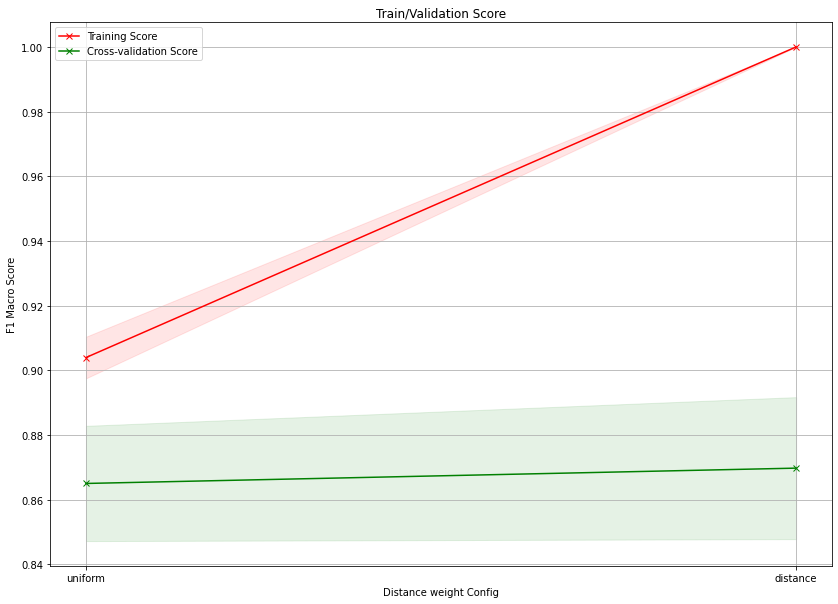

In [24]:
plot_learning_curve_hyper(df_weights, 'Distance weight Config', 'F1 Macro Score', 'Train/Validation Score')

In [25]:
from sklearn import neighbors
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

clf = KNeighborsClassifier()
# Test for best algorithm for computing distance btw neighbors
param_grid = [{'algorithm': ['ball_tree', 'kd_tree', 'brute', 'auto']}]
grid_search = GridSearchCV(clf, param_grid= param_grid, cv=5, n_jobs=-1,
                           return_train_score=True, scoring='f1_macro')

grid_search.fit(X_train_stand, y_train)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid=[{'algorithm': ['ball_tree', 'kd_tree', 'brute',
                                        'auto']}],
             return_train_score=True, scoring='f1_macro')

In [26]:
df_algo = pd.DataFrame(grid_search.cv_results_)
grid_search.best_params_

{'algorithm': 'ball_tree'}

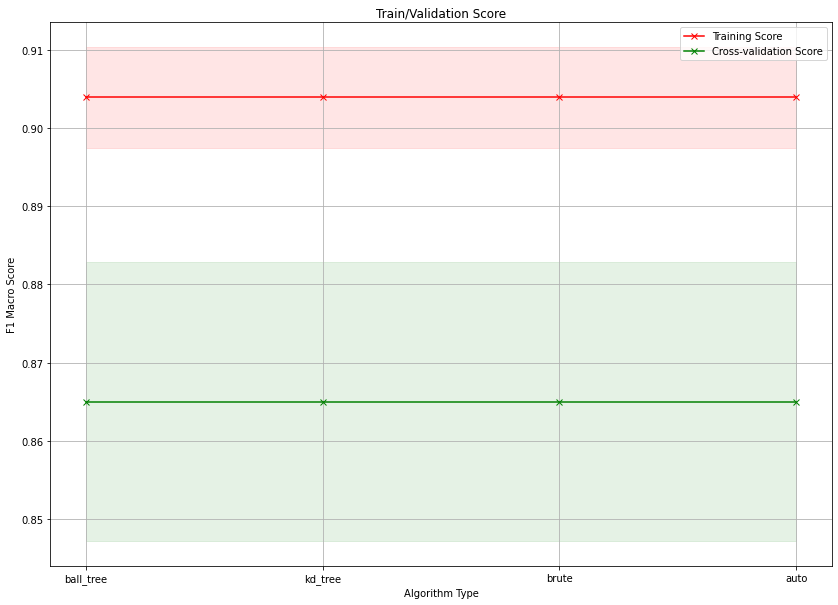

In [27]:
plot_learning_curve_hyper( df_algo, 'Algorithm Type', 'F1 Macro Score', 'Train/Validation Score')

In [28]:
from sklearn import neighbors
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

clf = KNeighborsClassifier()
# Test for best value for p (Minkowski Metric)
param_grid = [{'p': [i for i in range(1,5)]}]
grid_search = GridSearchCV(clf, param_grid= param_grid, cv=5, n_jobs=-1,
                           return_train_score=True, scoring='f1_macro')

grid_search.fit(X_train_stand, y_train)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid=[{'p': [1, 2, 3, 4]}], return_train_score=True,
             scoring='f1_macro')

In [29]:
df_p = pd.DataFrame(grid_search.cv_results_)
grid_search.best_params_  

{'p': 3}

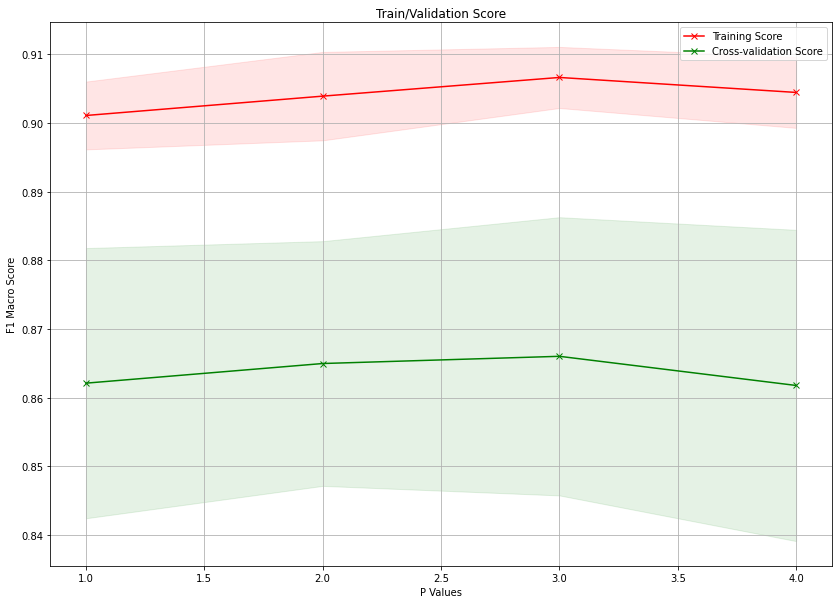

In [30]:
plot_learning_curve_hyper(df_p, 'P Values', 'F1 Macro Score', 'Train/Validation Score')

Established a KNN with its n_neighbor parameter set to "3" is achieving the Highest Accuracy

In [31]:
from sklearn import neighbors
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

clf = KNeighborsClassifier(n_neighbors=3)

clf.fit(X_train_stand, y_train)

KNeighborsClassifier(n_neighbors=3)

In [32]:
from sklearn.metrics import f1_score, classification_report
print(y_test.shape)
y_pred = clf.predict(X_test_stand)
print(f"F1 Weighted Score on Test Set: {f1_score(y_test, y_pred, average='macro'):.2f}")
print(f'\nClassification report on Training set:\n\n {classification_report(y_train, clf.predict(X_train_stand), zero_division=0)}')
print(f'\nClassification report on Test set:\n\n {classification_report(y_test, y_pred, zero_division=0)}')

(1250,)
F1 Weighted Score on Test Set: 0.88

Classification report on Training set:

               precision    recall  f1-score   support

           0       0.98      1.00      0.99      3390
           1       1.00      0.83      0.91       360

    accuracy                           0.98      3750
   macro avg       0.99      0.91      0.95      3750
weighted avg       0.98      0.98      0.98      3750


Classification report on Test set:

               precision    recall  f1-score   support

           0       0.97      0.99      0.98      1130
           1       0.92      0.67      0.77       120

    accuracy                           0.96      1250
   macro avg       0.94      0.83      0.88      1250
weighted avg       0.96      0.96      0.96      1250



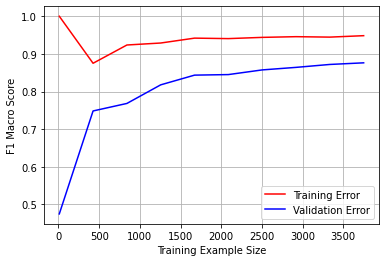

In [33]:
plot_learning_curve(clf, X, y, X_train=X_train_stand, X_val= X_test_stand, y_train= y_train, y_val=y_test)